# CAM을 만들고 평가해 보자

## 목차

1. 데이터 가져오기
2. 모델 가져오기 및 학습
3. CAM 구현하기
4. Grad-CAM 구현하기
5. 바운딩 박스 구하기
6. IoU 구하기
7. 회고

## 루브릭

|평가문항|상세기준|
|:----|:----|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

## 데이터 가져오기

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
import copy
from PIL import Image
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteAOGKP3/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteAOGKP3/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## 모델 가져오기 및 학습

In [4]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
# preds = ADD_YOUR_LAYER(x)
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 3s 0us/step


In [5]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [9]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 169s 201ms/step - loss: 2.2110 - accuracy: 0.4503 - val_loss: 3.3798 - val_accuracy: 0.2038
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.7074 - accuracy: 0.8067 - val_loss: 1.0147 - val_accuracy: 0.7026
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 0.1994 - accuracy: 0.9624 - val_loss: 0.9234 - val_accuracy: 0.7252
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0521 - accuracy: 0.9963 - val_loss: 0.8937 - val_accuracy: 0.7393
Epoch 5/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0209 - accuracy: 0.9994 - val_loss: 0.9146 - val_accuracy: 0.7387
Epoch 6/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9329 - val_accuracy: 0.7390
Epoch 7/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9398 -

In [11]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

cam_model_path = "/content/drive/MyDrive/ColabNotebooks/GoingDeeperCV/model/can_model.h5"
cam_model.save(cam_model_path)

Mounted at /content/drive


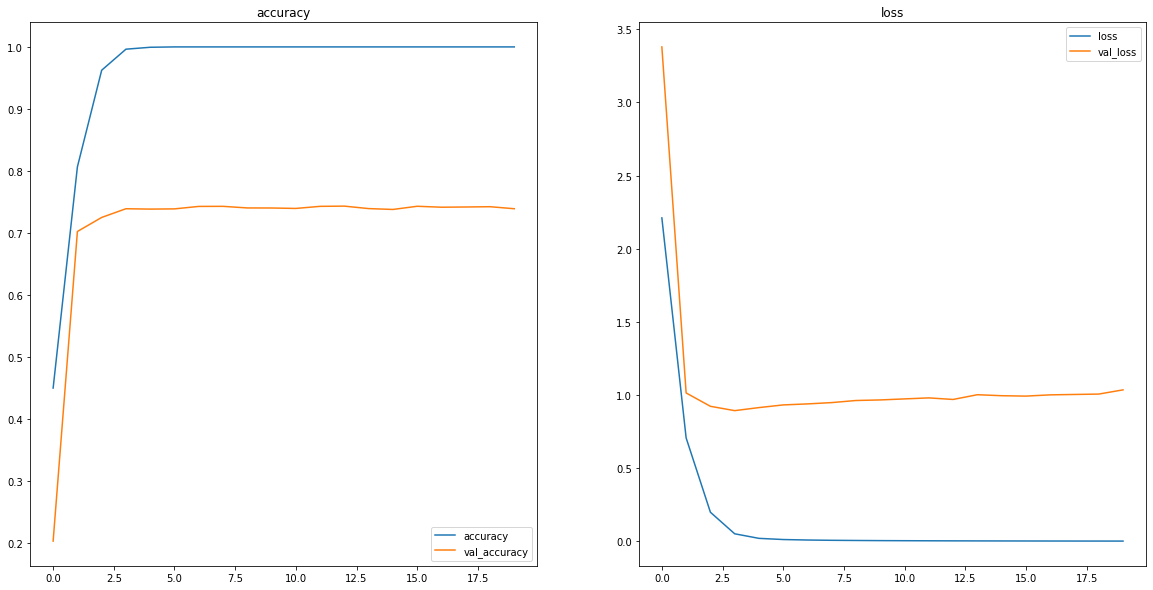

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(history_cam_model.history['accuracy'])
plt.plot(history_cam_model.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_cam_model.history['loss'])
plt.plot(history_cam_model.history['val_loss'])
plt.title('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## CAM 구현하기

In [20]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


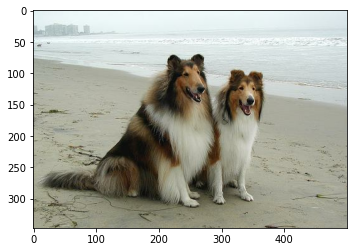

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [22]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

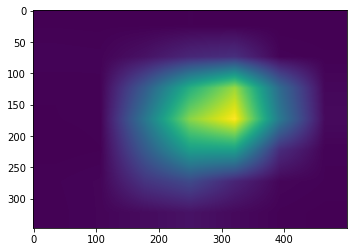

In [23]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [24]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

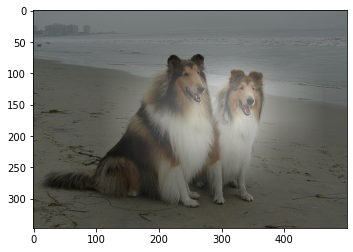

In [25]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM 구현하기

40


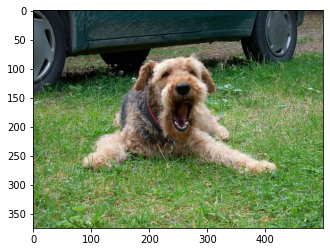

In [68]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [27]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

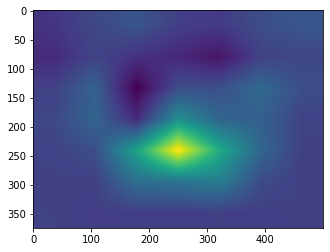

In [79]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

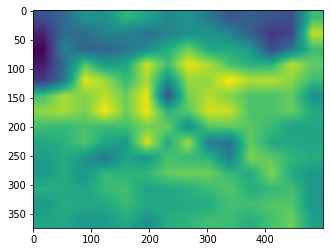

In [77]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

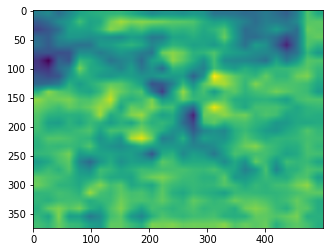

In [75]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

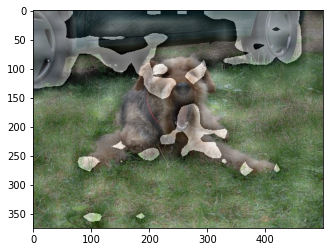

In [76]:
# conv3_block3_out
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

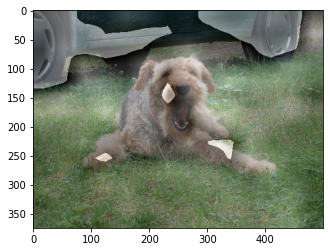

In [78]:
# conv4_block3_out
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

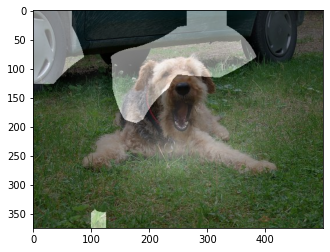

In [80]:
# conv5_block3_out
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 바운딩 박스 구하기

### CAM

40


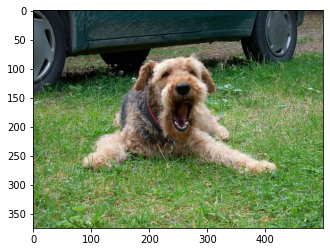

In [31]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

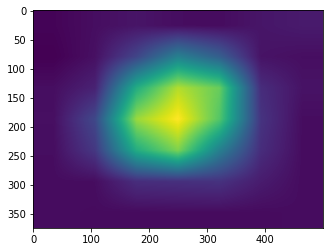

In [32]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [33]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [34]:
rect = get_bbox(cam_image)
rect

array([[431, 328],
       [ 48, 317],
       [ 56,  26],
       [439,  37]])

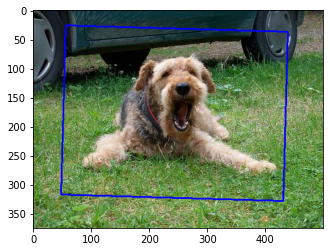

In [35]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Grad-CAM

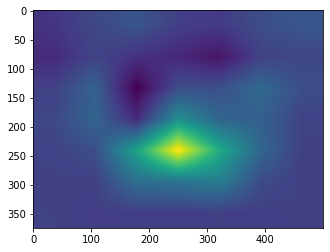

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [37]:
rect = get_bbox(grad_cam_image)
rect

array([[ 44, 339],
       [ 44,  92],
       [499,  92],
       [499, 339]])

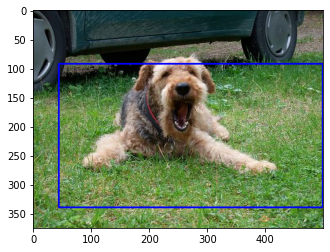

In [38]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

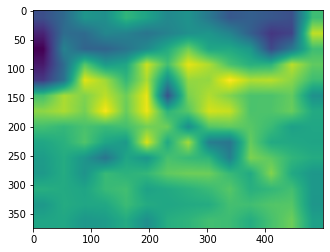

In [39]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [40]:
rect = get_bbox(grad_cam_image)
rect

array([[  0, 373],
       [  0,   0],
       [498,   0],
       [498, 373]])

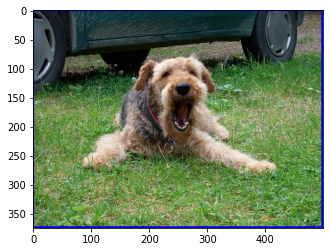

In [41]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

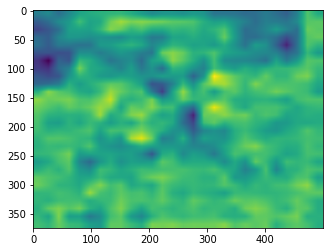

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [43]:
rect = get_bbox(grad_cam_image)
rect

array([[382,  62],
       [382,  59],
       [388,  59],
       [388,  62]])

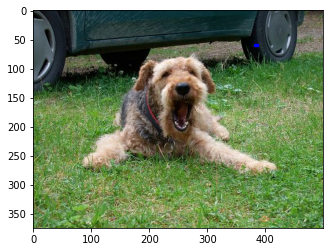

In [44]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## IoU 구하기

In [57]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [58]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

### CAM

In [59]:
cam_image = generate_cam(cam_model, item)
rect = get_bbox(cam_image)

In [60]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.06933333333333333, 0.096, 0.8746666666666667, 0.878]

In [61]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [62]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6042834336562091

### Grad-CAM

In [63]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
rect = get_bbox(grad_cam_image)

In [64]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.24533333333333332, 0.088, 0.904, 0.998]

In [65]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [66]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5429315412008515

## 회고

- iou
    - cam: 0.6
    - grad-cam: 0.54
- 바운딩 박스
    - cam: 정확히 인식한 것을 확인할 수 있습니다.
    - grad-cam: 아래 블록으로 갈수록 정확하게 인식하는 것을 알 수 있습니다.
- 모델이 이미지를 어떻게 인식하는지 확인할 좋은 기회가 되었습니다.